# Нейросетевой денойзинг

В этом ноутбуке я применю свои знания для решения новой для меня задачи --- задачи удаления шума с изображения. Для решения этой задачи мне предстоит пройти через следующие этапы:
1. Создание искусственного датасета (игрушечного, т.е. задача простая)
2. Написание архитектуры нейросети U-Net по картинке с её структурой
3. Обучение этой нейросети на задачу удаления шума на элементах игрушечного датасета

## Создание датасета

Датасет будет состоять из цветных изображений. Каждое из них для начала заполняется некоторым (случайным) цветом. Затем на этом фоне рисуются круги случайного размера в случайном месте изображения. Цвет этих кругов тоже случайный, но отличающийся от цвета фона по евклидовому расстоянию хотя бы на 50 единиц (пиксели от 0 до 255) для того, чтобы можно было визуально отличать эти круги от фона.

In [1]:
import torch
import torchvision
import random
from PIL import Image, ImageDraw


import numpy as np

from torch.utils.data import DataLoader, Dataset
from torch import nn

random.seed(1337)

In [2]:
class CircleDataset(Dataset):
    def __init__(self, size=(256, 256), transform=None, 
                 max_circle_rad=40, max_circle_num=5,
                 ds_len=1000, sigma=5):
        self.size = size
        self.transform = transform
        self.max_circle_rad = max_circle_rad
        self.max_circle_num = max_circle_num
        self.ds_len = ds_len
        self.sigma = sigma
        
    def __len__(self):
        return self.ds_len
    
    def __getitem__(self, idx):
        # Создание фона
        font_color = tuple(random.choices(range(256), k=3))
        img = Image.new("RGB", self.size, color=font_color)
        draw = ImageDraw.Draw(img)

        # Добавление кругов на фон
        for i in range(random.randint(0, self.max_circle_num)):
            circle_color = font_color
            while ((np.array(circle_color) - np.array(font_color))**2).sum()**0.5 < 50:
                circle_color = tuple(random.choices(range(256), k=3))
            
            circle_center_x = random.randint(0, self.size[0])
            circle_center_y = random.randint(0, self.size[1])
            circle_rad = random.randint(0, self.max_circle_rad)
            
            x_up_left, y_up_left = circle_center_x - circle_rad, circle_center_y - circle_rad
            x_down_right, y_down_right = circle_center_x + circle_rad, circle_center_y + circle_rad
            draw.ellipse((x_up_left, y_up_left, x_down_right, y_down_right), fill=circle_color, outline=circle_color)
                    
        # Добавление шума
        norm_noise = np.random.normal(0, self.sigma, size=(*self.size, 3)).astype(np.uint8)
        noised_img = np.asarray(img) + norm_noise
        noised_img = Image.fromarray(noised_img)
        
        if self.transform:
            noised_img = self.transform(noised_img)
            img = self.transform(img)
            
        return noised_img, img
        #return img, img

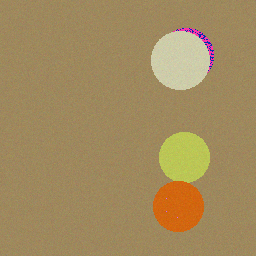

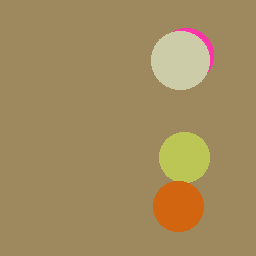

In [3]:
dataset = CircleDataset()
noised_img, clean_img = dataset[1]
display(noised_img)
display(clean_img)

In [4]:
dataset = CircleDataset(transform=torchvision.transforms.ToTensor())

## Создание архитектуры U-Net

Буду воспроизводить архитектуру по её схеме:

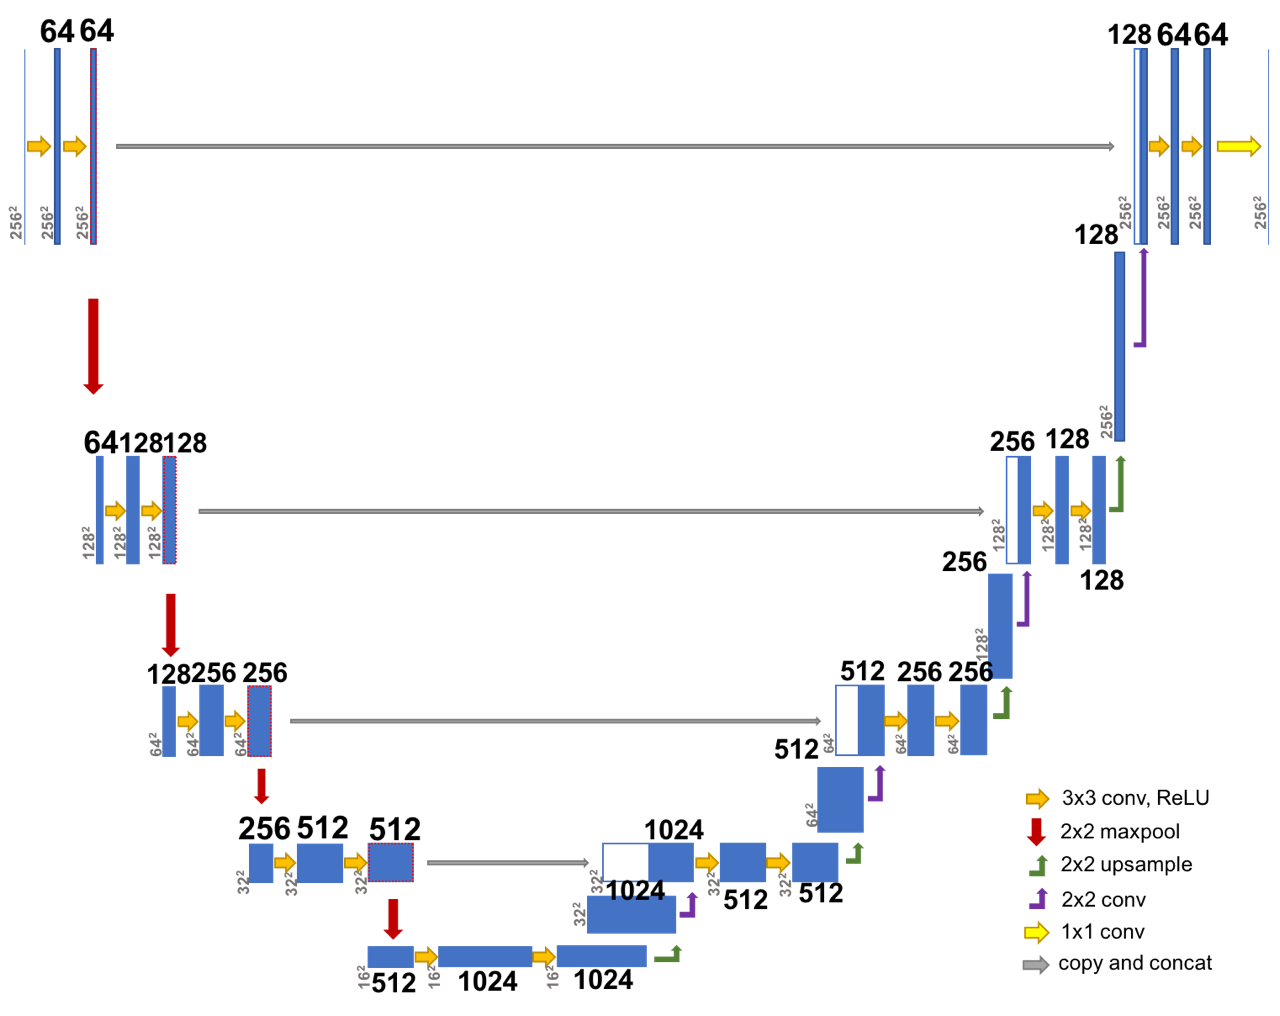

Разобью создание архитектуры на несколько этапов:
1. Создание блока Энкодера
2. Создание Энкодера целиком
3. Создание блока Декодера
4. Создание Декодера целиком
5. Создание полной архитектуры U-Net

In [5]:
class EncoderBlock(nn.Module):
    def __init__(self, in_feats, out_feats, batch_norm=True, dropout=True):
        super().__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout

        if batch_norm:
            self.batch1 = nn.BatchNorm2d(in_feats)
        self.conv1 = nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        if dropout:
          self.drop1 = nn.Dropout(0.15)

        if batch_norm:
            self.batch2 = nn.BatchNorm2d(out_feats)
        self.conv2 = nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        if dropout:
          self.drop2 = nn.Dropout(0.15)

    def forward(self, x):
        out = x

        if self.batch_norm:
            out = self.batch1(out)
        out = self.conv1(out)
        out = self.relu1(out)
        if self.dropout:
          out = self.drop1(out)

        if self.batch_norm:
            out = self.batch2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        if self.dropout:
          out = self.drop2(out)        

        return out

In [6]:
encoder_block = EncoderBlock(3, 64)

x = torch.rand([5, 3, 256, 256])
out = encoder_block(x)
print(x.shape)
print(out.shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 64, 256, 256])


In [7]:
class Encoder(nn.Module):
    def __init__(self, in_feats, filter_num=64, block_num=5):
        super().__init__()
        self.block_num = block_num
        
        for i in range(block_num):
            in_feats = in_feats if not i else filter_num * 2 ** (i - 1)
            out_feats = filter_num * 2 ** (i)
            self.add_module(f"block{i + 1}", EncoderBlock(in_feats, out_feats))
            if i != block_num - 1:
                self.add_module(f"pool{i + 1}", nn.MaxPool2d(kernel_size=2))
        
    def forward(self, x):
        residuals = []
        out = x
        
        for i in range(self.block_num):
            out = self.__getattr__(f"block{i + 1}")(out)
            residuals.append(out)
            if i != self.block_num - 1:
                out = self.__getattr__(f"pool{i + 1}")(out)
        
        return residuals

In [8]:
encoder = Encoder(3)

x = torch.rand([5, 3, 256, 256])
residuals = encoder(x)
print(*[_.shape for _ in residuals], sep='\n')

torch.Size([5, 64, 256, 256])
torch.Size([5, 128, 128, 128])
torch.Size([5, 256, 64, 64])
torch.Size([5, 512, 32, 32])
torch.Size([5, 1024, 16, 16])


In [9]:
class DecoderBlock(nn.Module):
    def __init__(self, out_feats, batch_norm=True, dropout=True, p=0.15):
        super().__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout

        self.relu = nn.ReLU()

        self.unpool = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        if batch_norm:
          self.upbatch = nn.BatchNorm2d(out_feats * 2)
        self.upconv = nn.Conv2d(out_feats * 2, out_feats, kernel_size=3, padding=1)
        self.uprelu = nn.ReLU()
        if dropout:
          self.updrop = nn.Dropout(p)

        if batch_norm:
          self.batch1 = nn.BatchNorm2d(out_feats * 2)
        self.conv1 = nn.Conv2d(out_feats * 2, out_feats, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        if dropout:
          self.drop1 = nn.Dropout(p)

        if self.batch_norm:
          self.batch2 = nn.BatchNorm2d(out_feats)
        self.conv2 = nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p)


    def forward(self, down, left):
        out = down
        out = self.unpool(out)
        if self.batch_norm:
          out = self.upbatch(out)
        out = self.upconv(out)
        out = self.uprelu(out)
        if self.dropout:
          out = self.updrop(out)

        cat = torch.cat([out, left], dim=1)
        if self.batch_norm:
          cat = self.batch1(cat)
        out = self.conv1(cat)
        out = self.relu1(out)
        if self.dropout:
          out = self.drop1(out)

        if self.batch_norm:
          out = self.batch2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        if self.dropout:
          out = self.drop2(out)

        return out

In [10]:
decoder_block = DecoderBlock(64)

down = torch.rand([5, 128, 128, 128])
left = torch.rand([5, 64, 256, 256])

decoder_block(down, left).shape

torch.Size([5, 64, 256, 256])

In [11]:
class Decoder(nn.Module):
    def __init__(self, filter_num=64, block_num=5):
        super().__init__()
        
        for i in range(block_num - 1, 0, -1):
            out_feats = filter_num * 2 ** (i - 1)
            self.add_module(f"block{block_num - i}", DecoderBlock(out_feats))
    
    def forward(self, residuals):
        out = residuals[-1]
        for i, left in enumerate(residuals[-2: : -1]):
            out = self.__getattr__(f"block{i + 1}")(out, left)
        return out

In [12]:
decoder = Decoder(64)
decoder

Decoder(
  (block1): DecoderBlock(
    (relu): ReLU()
    (unpool): Upsample(scale_factor=2.0, mode=bilinear)
    (upbatch): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (upconv): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (uprelu): ReLU()
    (updrop): Dropout(p=0.15, inplace=False)
    (batch1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (drop1): Dropout(p=0.15, inplace=False)
    (batch2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (drop2): Dropout(p=0.15, inplace=False)
  )
  (block2): DecoderBlock(
    (relu): ReLU()
    (unpool): Upsample(scale_factor=2.0, mode=bilinear)
    (upbatch): BatchNorm2d(512, eps=1e-05, momentum=0.1, 

In [13]:
x = torch.rand([5, 3, 256, 256])
residuals = encoder(x)
decoder(residuals).shape

torch.Size([5, 64, 256, 256])

In [14]:
class UNet(nn.Module):
    def __init__(self, in_feats, out_feats, filter_num=64, block_num=5):
        super().__init__()
    
        self.encoder = Encoder(in_feats, filter_num, block_num)
        self.decoder = Decoder(filter_num, block_num)
        self.final = nn.Conv2d(filter_num, out_feats, kernel_size=3, padding=1)
        
    
    def forward(self, x):
        residuals = self.encoder(x)
        out = self.decoder(residuals)
        out = torch.sigmoid(self.final(out))
        return out    

In [15]:
unet = UNet(3, 3)

In [16]:
unet

UNet(
  (encoder): Encoder(
    (block1): EncoderBlock(
      (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (drop1): Dropout(p=0.15, inplace=False)
      (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU()
      (drop2): Dropout(p=0.15, inplace=False)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block2): EncoderBlock(
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (drop1): Dropout(p=0.15, inplace=False)
      (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [17]:
x = torch.rand([5, 3, 256, 256])
unet(x).shape

torch.Size([5, 3, 256, 256])

## Обучение U-Net на игрушечном датасете

Выберем лосс-функцию, выберем оптимизатор, и вперёд!

In [18]:
def total_variation_loss(img, weight=0.01):
     bs_img, c_img, h_img, w_img = img.size()
     tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
     tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
     return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

In [19]:
!pip install piqa

  Created wheel for piqa: filename=piqa-1.1.8-py3-none-any.whl size=32565 sha256=583c4c2e6a5a878ba481bee94a0e9688dd710e6abdd1bf11dd4326594c17ddee
  Stored in directory: /root/.cache/pip/wheels/81/0a/2a/fae731d702ee7e8a06cc541f1bed070b7d5805348159579fe9
Successfully built piqa


In [20]:
unet = UNet(3, 3)
optim = torch.optim.Adam(unet.parameters())
#criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

from piqa import SSIM

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

criterion = SSIMLoss().cuda()

In [21]:
def train(model, train_dataloader, valid_dataloader, optim, criterion, epochs=10):
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    use_cuda = torch.cuda.is_available()
    # model = model.to(device)
    if use_cuda:
        model.cuda()
    model.train()  
    # Обучение
    for epoch in range(epochs):
        print(f"Epoch{epoch}:", end=' ')
        epoch_train_loss = []
        for distorted_img, reference_img in train_dataloader:
            optim.zero_grad()
            if use_cuda:
                distorted_img = distorted_img.cuda()
                reference_img = reference_img.cuda()
            cleaned_img = model(distorted_img)
            loss = criterion(cleaned_img, reference_img)
            loss.backward()
            optim.step()
            
            epoch_train_loss.append(loss)
        print(f"train loss == {sum(epoch_train_loss) / len(epoch_train_loss)}", end=' ')
        
        epoch_valid_loss = []
        #model.eval()
        for distorted_img, reference_img in valid_dataloader:
            with torch.no_grad():
                if use_cuda:
                    distorted_img = distorted_img.cuda()
                    reference_img = reference_img.cuda()
                cleaned_img = model(distorted_img)
                loss = criterion(cleaned_img, reference_img)
                epoch_valid_loss.append(loss)
        print(f"valid loss == {sum(epoch_valid_loss) / len(epoch_valid_loss)}")
    

In [22]:
transform = torchvision.transforms.Compose([
    #torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])
size = (64, 64)
train_dataloader = DataLoader(CircleDataset(size=size, ds_len=1000, transform=transform), 
                              batch_size=16)
valid_dataloader = DataLoader(CircleDataset(size=size, ds_len=200, transform=transform), 
                              batch_size=16)

In [59]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

train(unet, train_dataloader, valid_dataloader, optim, criterion, epochs=70)

Epoch0: train loss == 0.1151602491736412 valid loss == 0.12068373709917068
Epoch1: train loss == 0.11833684891462326 valid loss == 0.10869154334068298
Epoch2: train loss == 0.11660508811473846 valid loss == 0.1143050342798233
Epoch3: train loss == 0.11428294330835342 valid loss == 0.11049545556306839
Epoch4: train loss == 0.10902507603168488 valid loss == 0.11813396960496902
Epoch5: train loss == 0.11463689059019089 valid loss == 0.11596653610467911
Epoch6: train loss == 0.11415959894657135 valid loss == 0.10921472311019897
Epoch7: train loss == 0.1120273545384407 valid loss == 0.11814678460359573
Epoch8: train loss == 0.11042666435241699 valid loss == 0.11413691192865372
Epoch9: train loss == 0.10912580043077469 valid loss == 0.11060606688261032
Epoch10: train loss == 0.10994565486907959 valid loss == 0.11188152432441711
Epoch11: train loss == 0.10941766947507858 valid loss == 0.11208238452672958
Epoch12: train loss == 0.11148105561733246 valid loss == 0.10723290592432022
Epoch13: tra

In [60]:
import matplotlib.pyplot as plt

def plot_model_prediction(model, idx):
  dataset = CircleDataset(size=size, transform=transform)
  distorted_img, reference_img = dataset[idx]
  distorted_img = distorted_img.cuda()
  reference_img = reference_img.cuda()
  
  model.eval()
  cleaned_img = model(distorted_img.unsqueeze(0))


  fig = plt.figure(figsize=(15, 7))
  rows = 1
  cols = 3

  fig.add_subplot(rows, cols, 1)
  plt.title("Distorted", fontsize=16)
  plt.imshow(distorted_img.cpu().squeeze(0).transpose(0, 2))

  fig.add_subplot(rows, cols, 2)
  plt.title("Reference", fontsize=16)
  plt.imshow(reference_img.cpu().squeeze(0).transpose(0, 2))

  fig.add_subplot(rows, cols, 3)
  plt.title("Predicted", fontsize=16)
  plt.imshow(cleaned_img.detach().cpu().squeeze(0).squeeze(0).transpose(0, 2))

  plt.show()

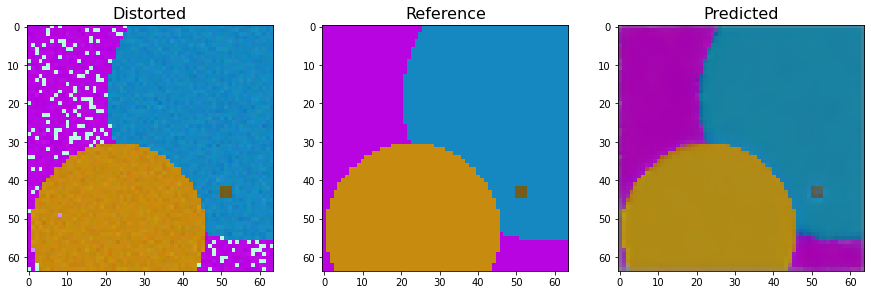

In [61]:
plot_model_prediction(unet, 0)

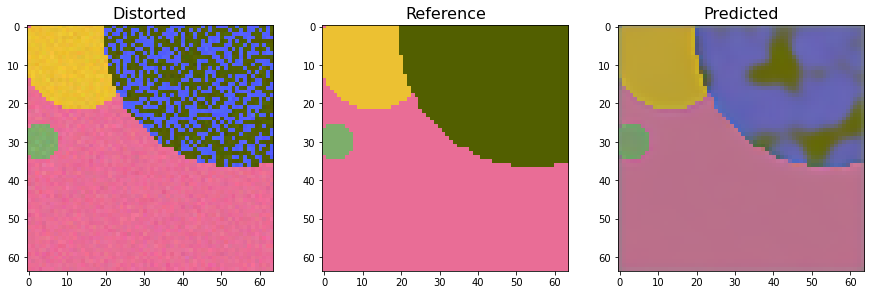

In [62]:
plot_model_prediction(unet, 1)

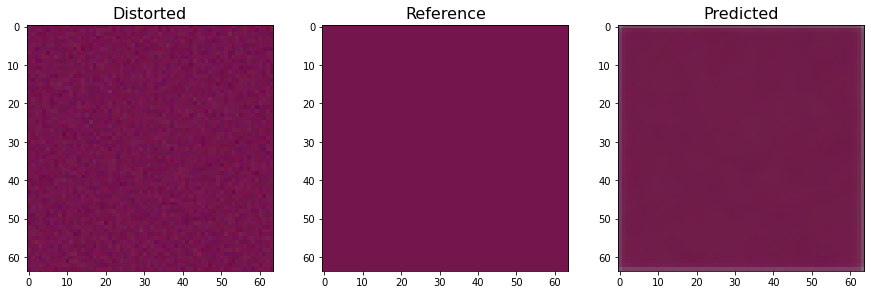

In [63]:
plot_model_prediction(unet, 2)

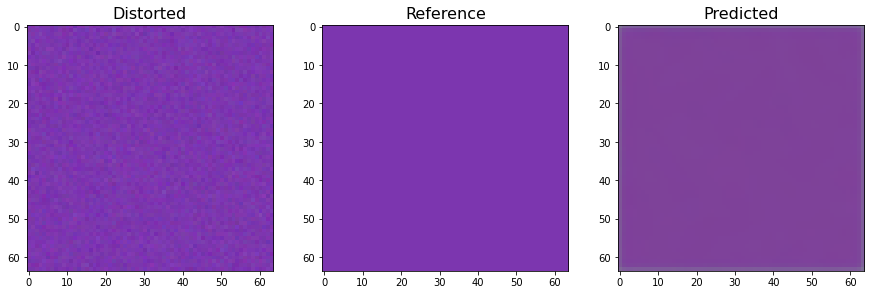

In [64]:
plot_model_prediction(unet, 3)

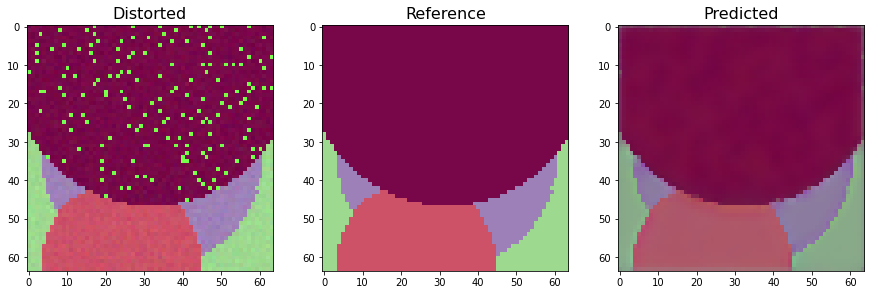

In [65]:
plot_model_prediction(unet, 4)